In [3]:
using Random, Statistics, PyPlot, Polynomials

In [4]:
using JLD # to save to file

# finding π

In [1]:
numOfIterations = 1_000_000_000
#xs_i = zeros(Float64,numOfIterations)
#ys_i = zeros(Float64,numOfIterations)
#xs_o = zeros(Float64,numOfIterations)
#ys_o = zeros(Float64,numOfIterations)
my_pi = zeros(Float64,floor(Int,log(10,numOfIterations))-1)
idx = zeros(Float64,floor(Int,log(10,numOfIterations))-1)
inside = 0.
j=1
i =1 
for i in range(1,stop = numOfIterations)
    x = rand(Float64)
    y = rand(Float64)
    if (x-0.5)^2 + (y-0.5)^2 < 0.5^2 #inside the circle
        #xs_i[i] = x
        #ys_i[i] = y
        inside += 1.
    end
    if isinteger(log(10,i))
        my_pi[j] =   4 * (inside / i)
        idx[j] = i
        j+=1
    end
    
    
end


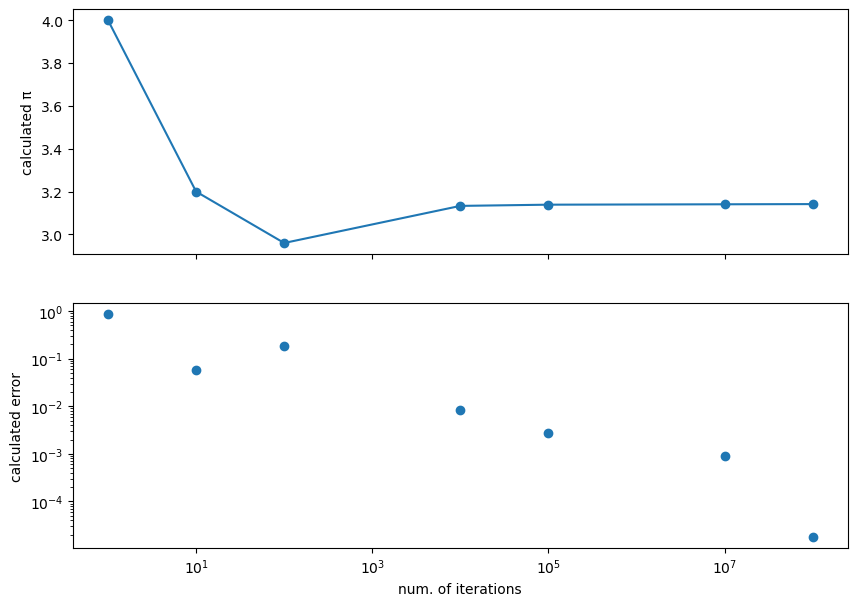

3.1416106
error is of the order of -5


In [12]:
fig, ax = subplots(2,1, figsize=(10,7),sharex=true)

ax[1].set_ylabel("calculated π")
ax[1].plot(idx,my_pi,"o-")
ax[2].set_ylabel("calculated error")
ax[2].scatter(idx,abs.(my_pi.- π))
yscale("log")
xscale("log")
#fig,ax = subplots(1,1,figsize=(5,5))
#ax.scatter(xs_i,ys_i,color="blue",s=0.5)
#ax.scatter(xs_o,ys_o,color="orange",s=0.5)
xlabel("num. of iterations")
println(my_pi[end])
error_scale = floor(Int,log(10,abs(my_pi[end]-π)))
println("error is of the order of $error_scale")


# XY MonteCarlo

In [15]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In our case, the configuration will be....  just an angle - meaning a number between 0 and 2π.


In [111]:
function XYConfigurationEnergy(lat::SquareLattice, c::Vector{Float64})
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec += -sum(map(x->cos(c[j]-c[x]),nn)) #Verify this 🎈
    end
    return Ec/4 # in the summation above every bond is included 4 times
end

XYConfigurationEnergy (generic function with 1 method)

In [100]:
function XYWolffUpdate!(lat::SquareLattice, c::Vector{Float64}, T::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    #define a random direction: ̂e
    direction = rand(Float64)*2π
    
    
            
    ind = rand(1:N) # pick a random site

    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors

    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        if j in cluster
            continue
        end
        si_e = cos(c[ind]-direction) # this gives the projection of si on ̂e 
        sj_e = cos(c[j]-direction) # this gives the projection of sj on ̂e 
        p = 1. - exp(-2/T * si_e*sj_e)
        if (si_e*sj_e < 0 )
            @assert p < 0
        end
        if rand() < p # if si_e and sj_e are unti-aligned  p will be negative (i might want to check this!🎈)    
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end

    #flip the cluster!
    ## theta'  = -theta -2alpha + pi
    c[cluster] = map(x->mod(x,2pi),-c[cluster] .- 2 * direction .+ pi)
    #c[cluster] = -c[cluster] .- 2 * direction .+ pi
end

XYWolffUpdate! (generic function with 1 method)

In [101]:
function XYMC(lat::SquareLattice, T::Float64, Nsw::Int64, saveConfigs = false)
    # Nsw is the number of sweeps to perform
    
    c = rand(Float64, length(lat)) * 2π

    if saveConfigs
        configs = zeros(Float64, Nsw, length(lat))
        configs[1, :] = c
    end
    
    mx = zeros(Float64, Nsw) # value of the X magnetization  per site
    my = zeros(Float64, Nsw) # value of the Y magnetization per site
    
    mx[1] = mean(map(x->cos(x),c))
    my[1] = mean(map(x->sin(x),c))
    
    
    En = zeros(Float64, Nsw)
    En[1] = XYConfigurationEnergy(lat, c)
    
    for i in range(2, stop=Nsw)
        XYWolffUpdate!(lat, c, T)
        En[i] = XYConfigurationEnergy(lat, c)
        
        if saveConfigs
            configs[i, :] = c
        end

        mx[i] = mean(map(x->cos(x),c))
        my[i] = mean(map(x->sin(x),c))
        

    end
    
    if saveConfigs
        return mx, my, En, configs
    else
        return mx, my, En
    end
    
end

XYMC (generic function with 2 methods)

In [102]:
function CalculateError(m, Neq, Nsw)
    err = Float64[]
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than number of sweeps after equilibration
    ml = m[end-Nsw2+1:end]
    min_size = 2^5
    while length(ml) > min_size
        push!(err, std(ml)/sqrt(length(ml)-1))
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1,stop=div(length(ml),2)) )
    end
    return err
end



CalculateError (generic function with 1 method)

# ...

In [12]:
Ts = [0.1,0.4, 0.5,0.6,0.9,0.95,1,1.1,1.15,1.2,1.3, 1.5];

In [16]:
Ls = [4,6,8,10,12,14,16,20,24,30,32,36]
for L in Ls
    N = L
    println(N)
    Ns = 100_000
    lattice = SquareLattice(N,N)
    mxs = zeros(Float64,Ns,length(Ts))
    mys = zeros(Float64,Ns,length(Ts))
    Ens = zeros(Float64,Ns,length(Ts))
    configs_vec = zeros(Float64,length(Ts),length(lattice))

    #Threads.@threads for (i,T) in enumerate(Ts)
    Threads.@threads for i in range(1,length=length(Ts))
        T = Ts[i]
        print("$T: ")
        @time mx,my,En,configs = XYMC(lattice,T,Ns,true);
        mxs[:,i] = mx
        mys[:,i] = my
        Ens[:,i] = En
        configs_vec[i,:] = configs[end,:]
        GC.gc()
    end
    file_name = "./tmp/auto_sweeps_$(Ns)_$(N).jld"
    save(file_name, "mxs", mxs, "mys", mys,"Ens",Ens,"configs_vec",configs_vec,"N",N,"Ns",Ns,"Ts",Ts)
    GC.gc()
end

4
0.1: 0.6: 1.2: 1.0:   1.105236 seconds (19.08 M allocations: 2.116 GiB, 45.33% gc time)
1.3:   1.265828 seconds (20.26 M allocations: 2.246 GiB, 49.11% gc time)
1.1:   1.421508 seconds (21.95 M allocations: 2.468 GiB, 50.78% gc time)
0.9:   1.561964 seconds (22.85 M allocations: 2.543 GiB, 53.30% gc time)
0.4:   1.189376 seconds (18.68 M allocations: 2.062 GiB, 50.63% gc time)
1.5:   1.202085 seconds (19.67 M allocations: 2.167 GiB, 48.61% gc time)
1.15:   1.293755 seconds (20.94 M allocations: 2.301 GiB, 49.44% gc time)
0.95:   1.371528 seconds (22.48 M allocations: 2.464 GiB, 48.95% gc time)
0.5:   1.133101 seconds (17.52 M allocations: 1.927 GiB, 49.98% gc time)
  1.073615 seconds (16.62 M allocations: 1.804 GiB, 42.33% gc time)
  1.409352 seconds (19.65 M allocations: 2.142 GiB, 49.30% gc time)
  1.295667 seconds (16.24 M allocations: 1.755 GiB, 41.06% gc time)
6
0.1: 1.0: 1.2: 0.6:   2.028734 seconds (34.22 M allocations: 4.016 GiB, 43.92% gc time)
1.3:   2.346945 seconds (38.29

In [ ]:
Neq = 100_00
Neq_s = [10,50,50,1000,1000,1000,1000,1000,10000,10000,10000]
aut_cor_times = []
figure(figsize=(10,10))
for (i,T) in enumerate(Ts)
    err = CalculateError(mxs[:,i], Neq_s[i], Ns)
    plot(2 .^ range(0, length=length(err)), err, "--o",label="$T")
    auto_cor_time = round(((err[end]/err[1])^2-1)/2)
    println("Autocorrelation time for $T : ", auto_cor_time )
    append!(aut_cor_times,auto_cor_time)
end

ylabel("Error")
xlabel("Bin size")
xscale("log")
legend()

show()

In [ ]:
plot(Ts,aut_cor_times,"-o")
ylabel("auto correlation time")
xlabel("Temperature")
yscale("log")
show()

In [ ]:
plot(Ts,mxs[end,:] .^2 + mys[end,:].^2,"-o")
ylabel("total magnetization")
xlabel("Temperature")
show()

In [17]:

fig = figure(figsize=(10,10))

for (i,T) in enumerate(Ts)
    ax = fig.add_subplot(ceil(Int,length(Ts)/3),3,i)
    ax.imshow((reshape(configs_vec[i,:],(N,N))),cmap="hsv",origin="lower")
    ax.set_title("T: $T")
    ax.axis("off")
end
show()

LoadError: UndefVarError: configs_vec not defined

In [13]:
X = range(1,N, step=1);
Y = range(1, N, step=1);
U = map(x->cos(x),reshape(configs_vec[6,:],(N,N)));
V = map(x->sin(x),reshape(configs_vec[6,:],(N,N)));
quiver(X,Y,U,V,scale=55,C=reshape(configs_vec[6,:],(N,N)))
show()

LoadError: UndefVarError: N not defined

In [151]:
Ns = 1_0000
N = 256
lattice = SquareLattice(N,N)
@time mx,my,En,configs = XYMC(lattice,0.5,Ns,true);


11383.366679 seconds (1.55 G allocations: 191.714 GiB, 0.06% gc time)


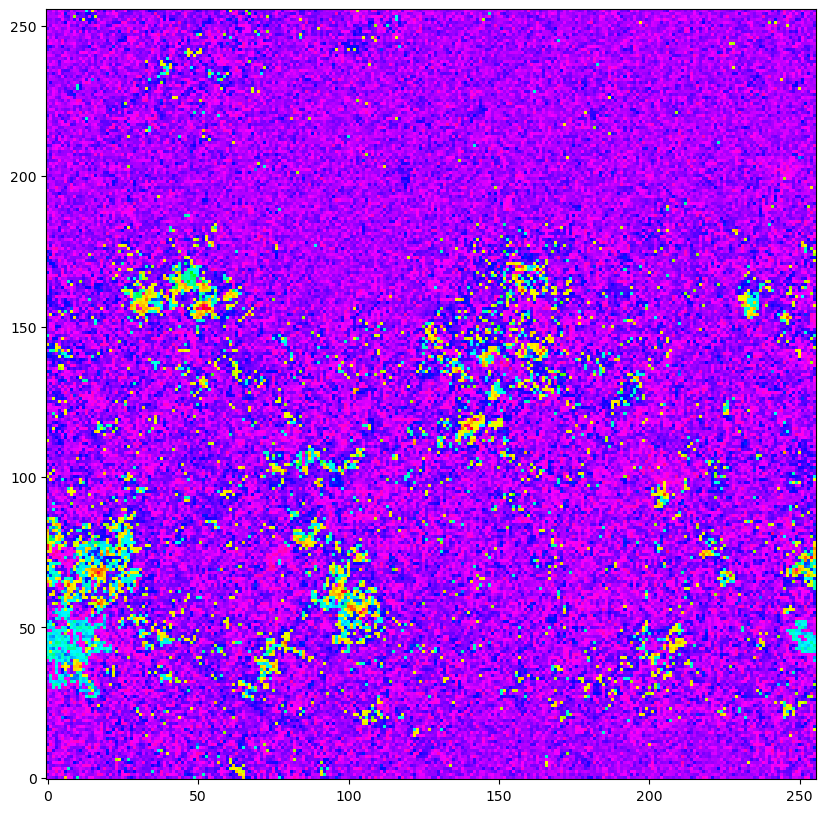

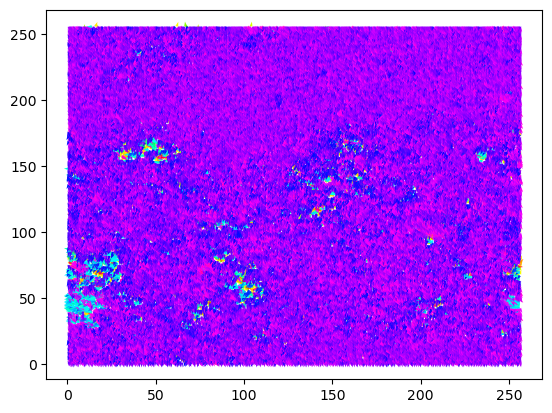

In [152]:
figure(figsize=(10,10))
conf = reshape(configs[end,:],(N,N))

imshow(reshape(configs[end,:],(N,N)),cmap="hsv",origin="lower")
show()
figure()
X = range(1,N, step=1);
Y = range(1, N, step=1);
U = map(x->cos(x),conf);
V = map(x->sin(x),conf);
q = quiver(X,Y,U,V,conf,cmap="hsv",scale=100)
show()

In [150]:
GC.gc()